# Importación de librerías y carga de datos

In [1]:
"""
Modulo de entrenamiento para diferentes pipelines de ML para el
entrenamiento utilizando los datasets creados. El flujo es capaz de 
generalizar en la mayoría de los casos y únicamente es necesario
realizar modificaciones en la ruta a los datos.

"""
import os
import pandas as pd 
import seaborn as sns                                                   
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    learning_curve, \
                                    RandomizedSearchCV, \
                                    GridSearchCV
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets, metrics
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from boruta import BorutaPy
from tpot import TPOTClassifier
import dataframe_image as dfi
from keras.models import Sequential,load_model,model_from_json


path_santiago = r'C:\Users\santi\Universidad de Antioquia\VALERIA CADAVID CASTRO - Resultados_Armonizacion_BD'
path_veronica = r'C:\Users\veroh\OneDrive - Universidad de Antioquia\Articulo análisis longitudinal\Resultados_Armonizacion_BD'
path_save =r'C:\Users\veroh\OneDrive - Universidad de Antioquia\Articulo análisis longitudinal\Resultados_Armonizacion_BD\Graficos_ML'
name = 'neuroHarmonize_G2G1'
path_plot = path_save + '/' + name
os.makedirs(path_plot,exist_ok=True)

In [2]:
def toJSON(model,path):
  # serialize model to JSON
  model_json = model.to_json()
  with open(path+'.json', "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(path+'.h5')
  print("Saved model to disk")

In [3]:
def loadModel(path):
  # load json and create model
  json_file = open(path+'.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(path+'.h5')
  print("Loaded model from disk")
  return loaded_model

In [4]:
path = path_veronica

In [5]:
modelos = {}
acc_per_feature = []
std_per_feature = []

In [6]:
data = pd.read_feather(r'{path}\Datosparaorganizardataframes\Data_complete_ic_neuroHarmonize_G2G1.feather'
                       .format(path=path))

In [7]:
data

,power_C14_Delta,power_C14_Theta,power_C14_Alpha-1,power_C14_Alpha-2,power_C14_Beta1,power_C14_Beta2,power_C14_Beta3,power_C14_Gamma,power_C15_Delta,power_C15_Theta,...,crossfreq_C24_Mbeta3_Gamma,crossfreq_C24_Mgamma_Gamma,crossfreq_C25_Mdelta_Gamma,crossfreq_C25_Mtheta_Gamma,crossfreq_C25_Malpha-1_Gamma,crossfreq_C25_Malpha-2_Gamma,crossfreq_C25_Mbeta1_Gamma,crossfreq_C25_Mbeta2_Gamma,crossfreq_C25_Mbeta3_Gamma,crossfreq_C25_Mgamma_Gamma
0,0.117850,0.046057,0.056491,0.067025,0.208902,0.116649,0.196712,0.190315,0.349848,0.075621,...,0.499025,3.494148,0.125094,0.017158,0.028082,0.042078,0.096900,0.027647,0.134862,0.771906
1,0.219402,0.081616,0.141171,0.090078,0.138479,0.077720,0.145238,0.106297,0.309420,0.105343,...,0.197225,0.896042,0.147602,0.034494,0.212442,0.156201,0.120427,0.023136,0.072372,0.208659
2,0.223536,0.080327,0.060129,0.063326,0.146483,0.046858,0.161582,0.217760,0.422397,0.133839,...,0.375054,1.741709,0.074851,0.016260,0.024914,0.045192,0.077056,0.018365,0.159608,0.462170
3,0.060384,0.053842,0.110616,0.118048,0.205379,0.071932,0.265876,0.113922,0.125735,0.121745,...,0.153976,0.581761,0.084725,0.032521,0.080483,0.107837,0.100563,0.022024,0.128888,0.336209
4,0.138757,0.072757,0.063151,0.070156,0.185047,0.080744,0.208584,0.180803,0.241525,0.120565,...,0.082797,0.240348,0.080951,0.043728,0.063810,0.083917,0.076265,0.015439,0.073012,0.192581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.071374,0.057007,0.133841,0.123366,0.300273,0.065056,0.167299,0.081786,0.181398,0.068315,...,0.082338,0.291175,0.124356,0.046084,0.072052,0.079191,0.146876,0.046600,0.098297,0.144826
97,0.116072,0.073341,0.113196,0.200202,0.244436,0.070249,0.114153,0.068351,0.194583,0.131112,...,0.062227,0.236743,0.081310,0.082335,0.127992,0.075248,0.071856,0.021422,0.075264,0.273901
98,0.172075,0.078325,0.099867,0.087229,0.158588,0.118175,0.146570,0.139170,0.170419,0.073329,...,0.318974,0.823492,0.096290,0.037469,0.079424,0.110924,0.249289,0.053553,0.162816,0.435582
99,0.214746,0.078244,0.077413,0.072385,0.220348,0.089559,0.139165,0.108139,0.465190,0.161911,...,0.102994,0.237311,0.078923,0.091082,0.214640,0.126139,0.080991,0.028524,0.093149,0.188226


In [8]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 101 | caracteristicas: 557


# Preprocesamiento

## Análisis exploratorio de datos

In [9]:
for group in data['group'].unique():
        
        print('{} : {}'.format(group, (data['group']==group).sum()))

G1 : 49
G2 : 52


In [10]:
data.describe()

,power_C14_Delta,power_C14_Theta,power_C14_Alpha-1,power_C14_Alpha-2,power_C14_Beta1,power_C14_Beta2,power_C14_Beta3,power_C14_Gamma,power_C15_Delta,power_C15_Theta,...,crossfreq_C24_Mbeta3_Gamma,crossfreq_C24_Mgamma_Gamma,crossfreq_C25_Mdelta_Gamma,crossfreq_C25_Mtheta_Gamma,crossfreq_C25_Malpha-1_Gamma,crossfreq_C25_Malpha-2_Gamma,crossfreq_C25_Mbeta1_Gamma,crossfreq_C25_Mbeta2_Gamma,crossfreq_C25_Mbeta3_Gamma,crossfreq_C25_Mgamma_Gamma
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.118852,0.070406,0.133041,0.139889,0.185669,0.072168,0.154732,0.125243,0.220783,0.110281,...,0.160575,0.820159,0.104776,0.058132,0.132915,0.137456,0.119605,0.027590,0.104888,0.380817
std,0.062464,0.032706,0.081996,0.085401,0.054263,0.027936,0.063082,0.100221,0.107490,0.053133,...,0.195381,1.792206,0.027024,0.029877,0.109881,0.127662,0.074501,0.015536,0.064383,0.376673
min,0.014434,0.011801,0.024681,0.036736,0.074928,0.021132,0.038331,-0.018578,0.036388,0.022455,...,0.006990,0.011967,0.051358,0.011296,0.014551,0.015207,0.024822,0.005553,0.017212,0.028591
25%,0.066125,0.049355,0.071707,0.077927,0.146130,0.052210,0.104777,0.065924,0.136968,0.075621,...,0.063501,0.167665,0.084725,0.037677,0.054546,0.054107,0.065946,0.016713,0.060648,0.143186
50%,0.104601,0.065950,0.111895,0.114371,0.185739,0.066976,0.146570,0.106436,0.206957,0.103581,...,0.108379,0.355231,0.100915,0.048067,0.091114,0.092251,0.103403,0.025155,0.092143,0.244183
75%,0.163348,0.087774,0.175893,0.189804,0.215550,0.088732,0.192561,0.149131,0.279149,0.125582,...,0.197225,0.860957,0.124356,0.076720,0.182270,0.164414,0.156165,0.035777,0.128888,0.431463
max,0.322974,0.211169,0.520641,0.467901,0.330047,0.180854,0.348554,0.500308,0.526322,0.311179,...,1.757985,17.144799,0.189475,0.169875,0.499168,0.618985,0.356541,0.089565,0.321180,1.980588


In [11]:
data.groupby(by='group').describe().T

group                                    G1         G2
power_C14_Delta            count  49.000000  52.000000
                           mean    0.107927   0.129147
                           std     0.056111   0.066816
                           min     0.014434   0.033730
                           25%     0.060384   0.081958
...                                     ...        ...
crossfreq_C25_Mgamma_Gamma min     0.053509   0.028591
                           25%     0.203047   0.132746
                           50%     0.356598   0.201072
                           75%     0.549551   0.330987
                           max     1.980588   1.337136

[4408 rows x 2 columns]

In [12]:
# eliminación de columnas con datos faltantes

for column in data.columns:

    if data[column].isna().sum() != 0:

        print('{} : {}'.format(column, (data[column].isna().sum())))
        data.drop(column, axis=1, inplace=True)

FAS_F : 40
FAS_S : 40
FAS_A : 40


In [13]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 101 | caracteristicas: 554


In [14]:
# Se mapean las clases 

clases_mapeadas = {label:idx for idx,label  
                   in enumerate(np.unique(data['group']))}

data.loc[:,'group'] = data.loc[:,'group'].map(clases_mapeadas) 
print(clases_mapeadas)

{'G1': 0, 'G2': 1}


C:\Users\veroh\AppData\Local\Temp\ipykernel_65144\383920285.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'group'] = data.loc[:,'group'].map(clases_mapeadas)


In [15]:
print(data.dtypes.unique())

[dtype('float64') dtype('O') dtype('int64')]


In [16]:
data.select_dtypes('O')

,database,participant_id,visit,condition,sex
0,BIOMARCADORES,sub-G1024,V0,CE,M
1,BIOMARCADORES,sub-G1023,V0,CE,F
2,BIOMARCADORES,sub-G1022,V0,CE,F
3,BIOMARCADORES,sub-G1021,V0,CE,F
4,BIOMARCADORES,sub-G1019,V0,CE,F
...,...,...,...,...,...
96,DUQUE,sub-ALZS019,V0,resting,F
97,DUQUE,sub-ALZS008,V0,resting,M
98,DUQUE,sub-ALZS022,V0,resting,M
99,DUQUE,sub-ALZS014,V0,resting,M


In [17]:
data.groupby(by='sex').describe().T

sex                                       F          M
power_C14_Delta            count  60.000000  41.000000
                           mean    0.111810   0.129158
                           std     0.054175   0.072402
                           min     0.034620   0.014434
                           25%     0.062912   0.074643
...                                     ...        ...
crossfreq_C25_Mgamma_Gamma min     0.072624   0.028591
                           25%     0.160919   0.131566
                           50%     0.239112   0.244183
                           75%     0.363229   0.525020
                           max     1.425511   1.980588

[4392 rows x 2 columns]

In [18]:
sexo_mapeado = {label:idx for idx,label
                in enumerate(np.unique(data['sex']))}

data.loc[:,'sex'] = data.loc[:,'sex'].map(sexo_mapeado) 
print(sexo_mapeado)

{'F': 0, 'M': 1}


C:\Users\veroh\AppData\Local\Temp\ipykernel_65144\2216644689.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'sex'] = data.loc[:,'sex'].map(sexo_mapeado)


In [19]:
# data pasa a ser el arreglo únicamente con los datos númericos

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data = data.select_dtypes(include=numerics)

data.shape

(101, 550)

In [20]:
# Se elimina la columna, para ponerla al final

target = data.pop('group')
data.insert(len(data.columns), target.name, target)

## Selección de caracteristicas

### Creación de datasets de entrenamiento y test

In [21]:
X = data.values[:,:-1]
y = data.values[:,-1]
print(X.shape)
print(y.shape)

(101, 549)
(101,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(                            
    X, # Valores de X
    y, # Valores de Y
    test_size=0.2, # Test de 20%
    random_state=1, # Semilla
    stratify=data.values[:,-1]) # que se mantenga la proporcion en la división

### Mapa de calor de correlación

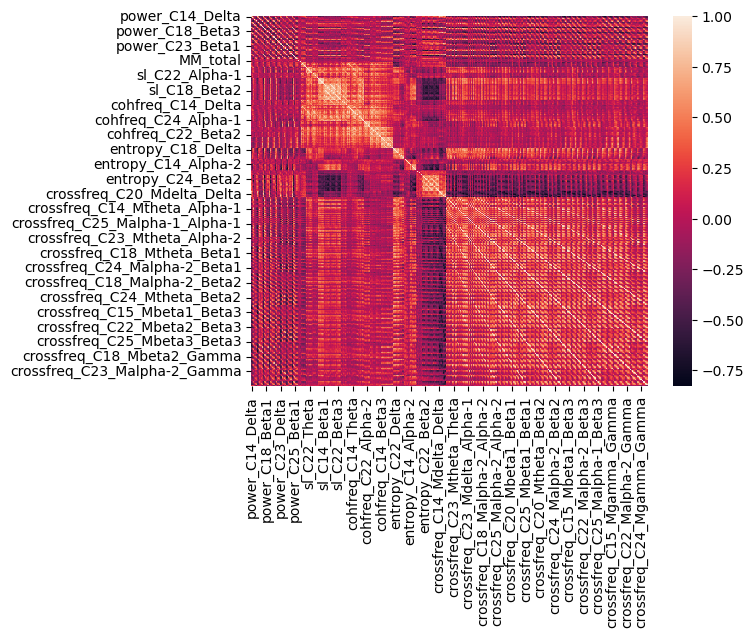

In [23]:
sns.heatmap(data.corr())
plt.savefig(path_plot+'/'+'correlation.png')

### Árboles de decisión (Grid Search)

In [24]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 30)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini',  'entropy', 'log_loss']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
               }

In [25]:
forestclf_grid = RandomForestClassifier()

rf_random = RandomizedSearchCV(
                              estimator=forestclf_grid,
                              param_distributions=random_grid,
                              n_iter=100,
                              cv=10,
                              verbose=2,
                              random_state=10,
                              n_jobs=-1
                              )

rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 165, 231, 296,
                                                         362, 427, 493, 558,
                                                         624, 689, 755, 820,
                                                         886, 951, 1017, 1082,
                                                         1148, 1213, 1279, 1344,
                                                         1410, 1475, 1541, 1606,
                                                         1672, 1737, 1803, 1868,
                                                         1934, 2000]},
                   random_state=10, verbose=2)

In [26]:
best_selected = rf_random.best_estimator_

In [27]:
GS_fitted = best_selected.fit(X_train, y_train)
modelos['GridSerach'] = GS_fitted

In [28]:
predicted = GS_fitted.predict(X_test)

In [29]:
print(
    f"Classification report for classifier {GS_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

Classification report for classifier RandomForestClassifier(bootstrap=False, criterion='entropy', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=689):
              precision    recall  f1-score   support

         0.0       0.46      0.60      0.52        10
         1.0       0.50      0.36      0.42        11

    accuracy                           0.48        21
   macro avg       0.48      0.48      0.47        21
weighted avg       0.48      0.48      0.47        21




In [30]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T

In [31]:
path_plot

'C:\\Users\\veroh\\OneDrive - Universidad de Antioquia\\Articulo análisis longitudinal\\Resultados_Armonizacion_BD\\Graficos_ML/neuroHarmonize_G2G1'

In [32]:
dfi.export(dataframe_metrics, path_plot+'/'+'metrics.png')

SyntaxError: not a PNG file (<string>)

In [ ]:
scores = cross_val_score(
                        estimator=GS_fitted,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )

In [ ]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.66666667 0.66666667 0.66666667 0.83333333 0.58333333 0.58333333
 0.41666667 0.63636364 0.72727273 0.81818182]


In [ ]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))

acc_per_feature.append(np.mean(scores))
std_per_feature.append(np.std(scores))


CV accuracy: 0.660 +/- 0.115


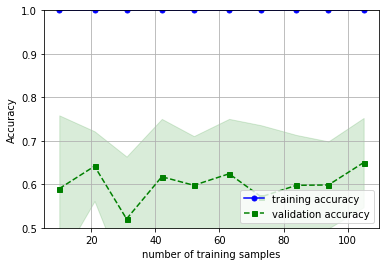

In [ ]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=GS_fitted,
                  X=X_train,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_GridSearch.png')
plt.show()

### Árboles de decisión (Boruta)

In [ ]:
feat_selector = BorutaPy(
                        verbose=2,
                        estimator=best_selected,
                        max_iter=100,
                        random_state=10
                        )

In [ ]:
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	545
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	545
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	545
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	545
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	545
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	545
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	545
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	545
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1


BorutaPy(estimator=RandomForestClassifier(bootstrap=False, max_depth=20,
                                          n_estimators=1000,
                                          random_state=RandomState(MT19937) at 0x1F21E47E140),
         random_state=RandomState(MT19937) at 0x1F21E47E140, verbose=2)

In [ ]:
selected_features = []
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", data.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
        selected_features.append(data.columns[i])


------Support and Ranking for each feature------
Passes the test:  power_C18_Gamma  - Ranking:  1
Passes the test:  power_C20_Gamma  - Ranking:  1


In [ ]:
X_transform = feat_selector.transform(X_train)

In [ ]:
boruta_fitted = best_selected.fit(X_transform, y_train)
modelos['Boruta'] = boruta_fitted

In [ ]:
selected_features = [data.columns.get_loc(c) for c in selected_features if c in data]
selected_features

[23, 31]

In [ ]:
predicted = boruta_fitted.predict(X_test[:,selected_features])

In [ ]:
print(
    f"Classification report for classifier {boruta_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=1000,
                       random_state=RandomState(MT19937) at 0x1F21E47E140):
              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87        20
         1.0       0.73      0.80      0.76        10

    accuracy                           0.83        30
   macro avg       0.81      0.82      0.82        30
weighted avg       0.84      0.83      0.84        30




In [ ]:
scores = cross_val_score(estimator=boruta_fitted,
                        X=X_transform,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)

In [ ]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.83333333 0.58333333 0.75       0.83333333 0.66666667 0.75
 0.66666667 0.72727273 0.63636364 0.81818182]


In [ ]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))


acc_per_feature.append(np.mean(scores))
std_per_feature.append(np.std(scores))


CV accuracy: 0.727 +/- 0.083


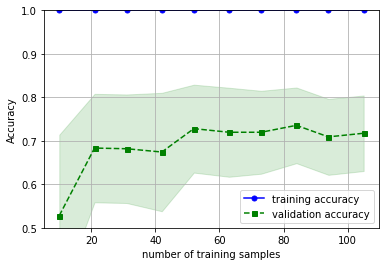

In [ ]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=boruta_fitted,
                  X=X_transform,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_Boruta.png')
plt.show()

### Selección de caracteristicas con árboles de decisión

 1) power_C20_Gamma                0.031994
 2) power_C18_Gamma                0.016207
 3) power_C24_Gamma                0.014799
 4) power_C25_Gamma                0.012640
 5) power_C14_Gamma                0.012157
 6) crossfreq_C20_Mgamma_Gamma     0.010786
 7) power_C23_Gamma                0.010265
 8) cohfreq_C25_Beta1              0.009142
 9) sl_C18_Theta                   0.008787
10) sl_C15_Beta3                   0.008048
11) cohfreq_C15_Delta              0.008034
12) cohfreq_C18_Beta2              0.007587
13) cohfreq_C25_Theta              0.007554
14) sl_C15_Alpha-1                 0.007402
15) cohfreq_C15_Theta              0.007304
16) crossfreq_C25_Mgamma_Gamma     0.007272
17) power_C15_Gamma                0.006911
18) sl_C25_Alpha-1                 0.006724
19) sl_C18_Delta                   0.006533
20) cohfreq_C18_Beta1              0.006336
21) crossfreq_C14_Mgamma_Gamma     0.005852
22) crossfreq_C24_Mbeta3_Beta3     0.005714
23) cohfreq_C23_Beta3           

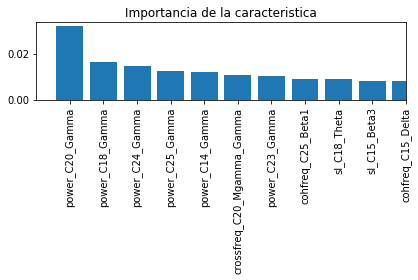

In [ ]:
nombres_columnas = data.columns[:-1]
best_selected.fit(X_train, y_train)
features_scores = best_selected.feature_importances_
features_scores
index = np.argsort(features_scores)[::-1]
sorted_names = []

for f in range(X_train.shape[1]):

    sorted_names.append(nombres_columnas[index[f]])
    print("%2d) %-*s %f" % (f + 1, 30,
                        nombres_columnas[index[f]],
                        features_scores[index[f]]))
    
plt.title('Importancia de la caracteristica')

plt.bar(range(X_train.shape[1]),
    features_scores[index],
    align='center')

plt.xticks(range(X_train.shape[1]),
    nombres_columnas[index],
    rotation=90)

plt.xlim([-1, 10])

plt.tight_layout()

plt.show()

In [ ]:
for index, feature_name in enumerate(sorted_names,start=1):

    input_features_names = sorted_names[:index]
    input_features_index = [data.columns.get_loc(c) for c 
                      in input_features_names if c in data]
    feature_model = best_selected.fit(X_train[:, input_features_index], y_train)
    scores = cross_val_score(
                        estimator=feature_model,
                        X=X_train[:, input_features_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    modelos['number_features_' + str(index)] = feature_model
    acc_per_feature.append(np.mean(scores))
    std_per_feature.append(np.std(scores))

plt.plot(
        range(1, len(sorted_names)),
        acc_per_feature,
        color='red'
        ) 

plt.fill_between(
                range(1, len(sorted_names)),
                np.array(acc_per_feature) + np.array(std_per_feature),
                np.array(acc_per_feature) - np.array(std_per_feature),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.savefig(path_plot+'/'+'features_plot.png')
plt.show()


KeyboardInterrupt: 

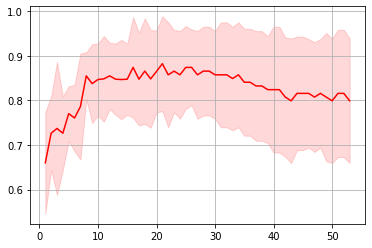

In [ ]:
plt.plot(
        list(range(1, len(sorted_names)))[:53],
        acc_per_feature,
        color='red'
        ) 

plt.fill_between(
                list(range(1, len(sorted_names)))[:53],
                np.array(acc_per_feature) + np.array(std_per_feature),
                np.array(acc_per_feature) - np.array(std_per_feature),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.savefig(path_plot+'/'+'features_plot.png')
plt.show()

In [ ]:
pos_model = np.argsort(acc_per_feature)[-1]
best_model = list(modelos.keys())[pos_model]
best_model

'number_features_19'

In [ ]:
toJSON(list(modelos.values())[best_model],path_plot+'/'+list(modelos.keys())[best_model])

In [ ]:
best_features=sorted_names[:pos_model]

### SVM (Grid Search)

In [ ]:
svm_param_grid = {'C': list(np.logspace(-1, 4, 6)), 
                 'gamma': list(np.logspace(-3, 2, 6)) + ['Auto'] + ['scale'],
                 'kernel': ['rbf', 'poly']} 

svc = SVC()
svc_clf = GridSearchCV(
                      svc,
                      svm_param_grid,
                      n_jobs=-1,
                      cv=10
                      )

svm_best_clf = svc_clf.fit(X_train, y_train)
best_model = svm_best_clf.best_estimator_

In [ ]:
best_model.fit(X_train, y_train)

In [ ]:
predicted = best_model.predict(X_test)

In [ ]:
print(
    f"Classification report for classifier {best_model}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

### SVM (Permutation importance)

In [ ]:
# results = permutation_importance(
#                                 best_model,
#                                 X_train,
#                                 y_train,
#                                 scoring='accuracy'
#                                 )

# nombres_columnas = data.columns[:-1]
# importance = results.importances_mean
# index = np.argsort(importance)

# for v, idx in zip(importance, index):
    
#     print(f'Feature: {nombres_columnas[idx]} | Score: {v}')


### SVM con caracteristicas seleccionadas del árbol de decisión

In [ ]:
acc_per_feature = []
std_per_feature = []

for index, feature_name in enumerate(sorted_names,start=1):

    input_features_names = sorted_names[:index]
    input_features_index = [data.columns.get_loc(c) for c 
                      in input_features_names if c in data]
    best_model.fit(X_train[:, input_features_index], y_train)
    scores = cross_val_score(
                        estimator=best_model,
                        X=X_train[:, input_features_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    acc_per_feature.append(np.mean(scores))
    std_per_feature.append(np.std(scores))

plt.plot(
        range(1, len(sorted_names)),
        acc_per_feature,
        color='red'
        ) 

plt.fill_between(
                range(1, len(sorted_names)),
                acc_per_feature + std_per_feature,
                acc_per_feature - std_per_feature,
                alpha=0.15,
                color='red'
                )

plt.grid()

### XGBoosting

### TPOT

In [ ]:
pipeline_optimizer = TPOTClassifier()

In [ ]:
pipeline_optimizer = TPOTClassifier(
                                    generations=5,
                                    population_size=int(X.shape[0]*0.4),
                                    cv=10,
                                    random_state=10,
                                    verbosity=3,
                                    n_jobs=-1
                                    )

In [ ]:
pipeline_optimizer.fit(X_train, y_train)

In [ ]:
print(pipeline_optimizer.score(X_test, y_test))